<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-30.1" data-toc-modified-id="Figure-30.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 30.1</a></span></li><li><span><a href="#Figure-30.2" data-toc-modified-id="Figure-30.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 30.2</a></span></li><li><span><a href="#Figure-30.3" data-toc-modified-id="Figure-30.3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 30.3</a></span></li><li><span><a href="#Figure-30.4" data-toc-modified-id="Figure-30.4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 30.4</a></span></li><li><span><a href="#Figure-30.5" data-toc-modified-id="Figure-30.5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 30.5</a></span></li><li><span><a href="#Figure-30.6" data-toc-modified-id="Figure-30.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 30.6</a></span></li><li><span><a href="#Figure-30.7" data-toc-modified-id="Figure-30.7-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 30.7</a></span></li><li><span><a href="#Figure-30.8a" data-toc-modified-id="Figure-30.8a-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 30.8a</a></span></li><li><span><a href="#Figure-30.9" data-toc-modified-id="Figure-30.9-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 30.9</a></span></li><li><span><a href="#Figure-30.10" data-toc-modified-id="Figure-30.10-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Figure 30.10</a></span></li><li><span><a href="#Figure-30.11" data-toc-modified-id="Figure-30.11-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Figure 30.11</a></span></li><li><span><a href="#Figure-30.12" data-toc-modified-id="Figure-30.12-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Figure 30.12</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 30
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io

from scipy import signal as sig
from scipy import stats

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))
    
#chan2useidx = chan_labels.index('Pz')

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 30.1

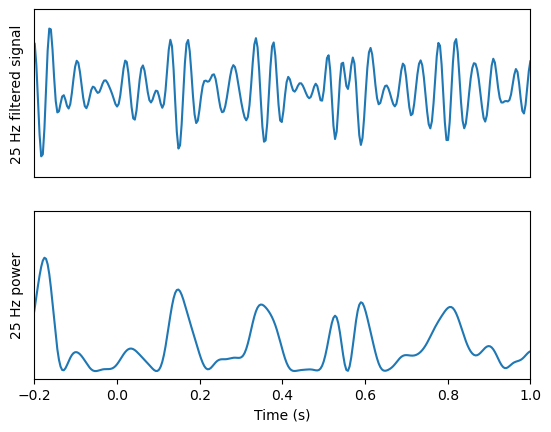

In [4]:
# wavelet parameters
freq2plot = 25

# other wavelet parameters
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = int((len(time)-1)/2)
n_wavelet     = len(time)
n_data        = pnts*trials
n_convolution = n_wavelet+n_data-1

# find sensor index
sensoridx =  chan_labels.index('O1')

# FFT of data
fft_EEG = np.fft.fft(data[:, sensoridx,:].flatten(),n_convolution)

# create wavelet and get its FFT
wavelet = np.exp(2 * 1j * np.pi * freq2plot * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq2plot))**2))
fft_wavelet = np.fft.fft(wavelet, n_convolution)


convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
convolution_result = np.reshape(convolution_result, [pnts, trials], order='F')


plt.figure()


plt.subplot(211)
plt.plot(times, np.real(convolution_result[:, 0])) # filtered signal from the first trial
plt.setp(plt.gca(), 'xlim', [-.2, 1],'xticks', [], 'yticks', [],'ylabel', '25 Hz filtered signal')

plt.subplot(212)
plt.plot(times, np.abs(convolution_result[:, 0])**2) # power from the first trial
plt.setp(plt.gca(), 'xlim', [-.2, 1], 'yticks', [], 'xlabel', 'Time (s)', 'ylabel', '25 Hz power', )

plt.show()

## Figure 30.2

In [5]:
data_ = scipy.io.loadmat('./NeuralData/accumbens_eeg.mat')
eeg = data_['eeg']

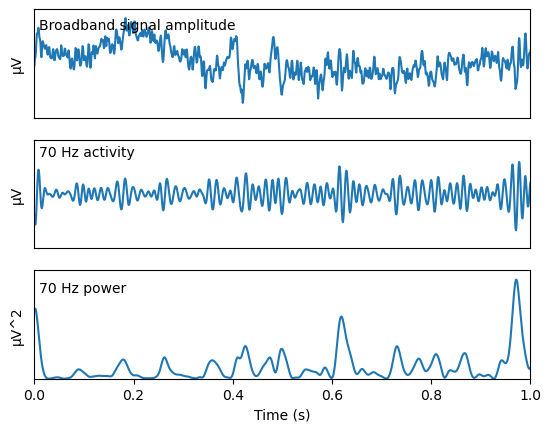

In [6]:
s_rate = 1000

# wavelet parameters
freq2plot = 70

# other wavelet parameters
time = np.arange(-1, 1 + 1/s_rate, 1/s_rate)
half_of_wavelet_size = int((len(time)-1)/2)
n_wavelet     = len(time)
n_data        = np.shape(eeg)[1]
n_convolution = n_wavelet+n_data-1

# FFT of data
fft_EEG = np.fft.fft(eeg.flatten(),n_convolution)

# create wavelet and get its FFT
wavelet = np.exp(2 * 1j * np.pi * freq2plot * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq2plot))**2))
fft_wavelet = np.fft.fft(wavelet, n_convolution)

convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]

eegtime = np.arange(0,np.shape(eeg)[1])/s_rate

plt.figure
plt.subplot(311)
plt.plot(eegtime,eeg.flatten())
plt.setp(plt.gca(),'xlim',[0, 1], 'ylim', [-400, 0], 'xticks', [], 'yticks', [], 'ylabel', 'μV')
plt.text(.01, -75, 'Broadband signal amplitude')

plt.subplot(312)
plt.plot(eegtime,np.real(convolution_result)) # filtered signal from the first trial
plt.setp(plt.gca(),'xlim',[0, 1], 'ylim', [-1000, 1000], 'xticks', [], 'yticks', [], 'ylabel', 'μV')
plt.text(.01, 700, '70 Hz activity')

plt.subplot(313)
plt.plot(eegtime,np.abs(convolution_result)**2) # power from the first trial
plt.setp(plt.gca(),'xlim',[0, 1], 'ylim', [0, 500000], 'yticks', [], 'xlabel', 'Time (s)', 'ylabel', 'μV^2')
_=plt.text(.01,400000, '70 Hz power')

## Figure 30.3

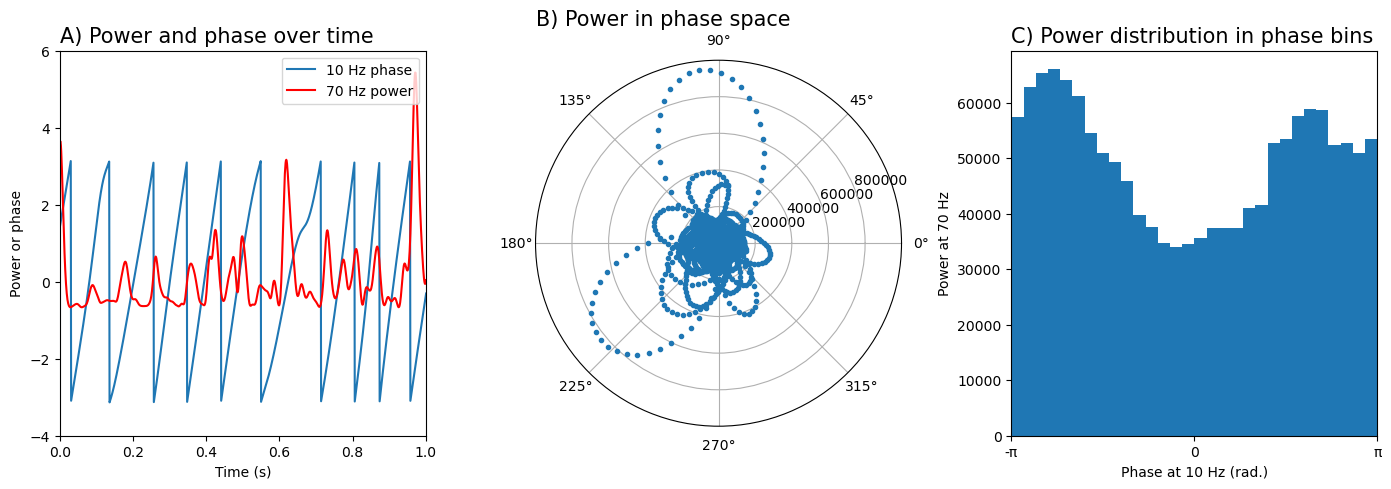

In [7]:
# we will first test for cross-frequency coupling between two specific frequency bands
freq4phase = 10 # in Hz
freq4power = 70 

srate = 1000
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = int((len(time)-1)/2)
n_wavelet     = len(time)
n_data        = np.shape(eeg)[1]
n_convolution = n_wavelet+n_data-1
fft_data = np.fft.fft(eeg.flatten(),n_convolution);


# wavelet for phase and its FFT
wavelet4phase = np.exp(2*1j*np.pi*freq4phase*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq4phase))**2))
fft_wavelet4phase = np.fft.fft(wavelet4phase,n_convolution)

# wavelet for power and its FFT
wavelet4power = np.exp(2*1j*np.pi*freq4power*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq4power))**2))
fft_wavelet4power = np.fft.fft(wavelet4power,n_convolution)

# get phase values
convolution_result_fft = np.fft.ifft(fft_wavelet4phase*fft_data, n_convolution)
phase = np.angle(convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size])

# get power values (note: 'power' is a built-in function so we'll name this variable 'amp')
convolution_result_fft = np.fft.ifft(fft_wavelet4power*fft_data,n_convolution)
pwr = np.abs(convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size])**2

# plot power and phase
plt.figure(figsize=(17,5))
plt.subplots_adjust(wspace=.3)

plt.subplot(131)
plt.plot(eegtime,phase)
plt.plot(eegtime,(pwr-np.mean(pwr))/np.std(pwr),'r')
plt.legend(['10 Hz phase','70 Hz power'], loc='upper right')
plt.setp(plt.gca(),'xlim',[0, 1], 'ylim', [-4,6], 'ylabel', 'Power or phase', 'xlabel', 'Time (s)')
plt.title('A) Power and phase over time', loc='left', fontsize=15)

# plot power as a function of phase in polar space
plt.subplot(132, polar=True)
plt.polar(phase,pwr,'.')
plt.title('B) Power in phase space', loc='left', fontsize=15)

# plot histogram of power over phase
n_hist_bins = 30

phase_edges = np.linspace(np.min(phase), np.max(phase), n_hist_bins + 1)
amp_by_phases = np.array([np.mean(pwr[(phase > phase_edges[i]) & (phase < phase_edges[i + 1])]) for i in range(n_hist_bins)])


plt.subplot(133)
plt.bar(phase_edges[:-1], amp_by_phases, align='edge', width=np.diff(phase_edges).mean())
plt.xlim([-np.pi, np.pi])



plt.setp(plt.gca(),'xlim',[phase_edges[1], phase_edges[-1]],'xlabel', f'Phase at {freq4phase} Hz (rad.)', 'ylabel', f'Power at {freq4power} Hz')
plt.title('C) Power distribution in phase bins', loc='left', fontsize=15)
_=plt.xticks([-np.pi, 0, np.pi], ['-π', 0,'π'])

## Figure 30.4

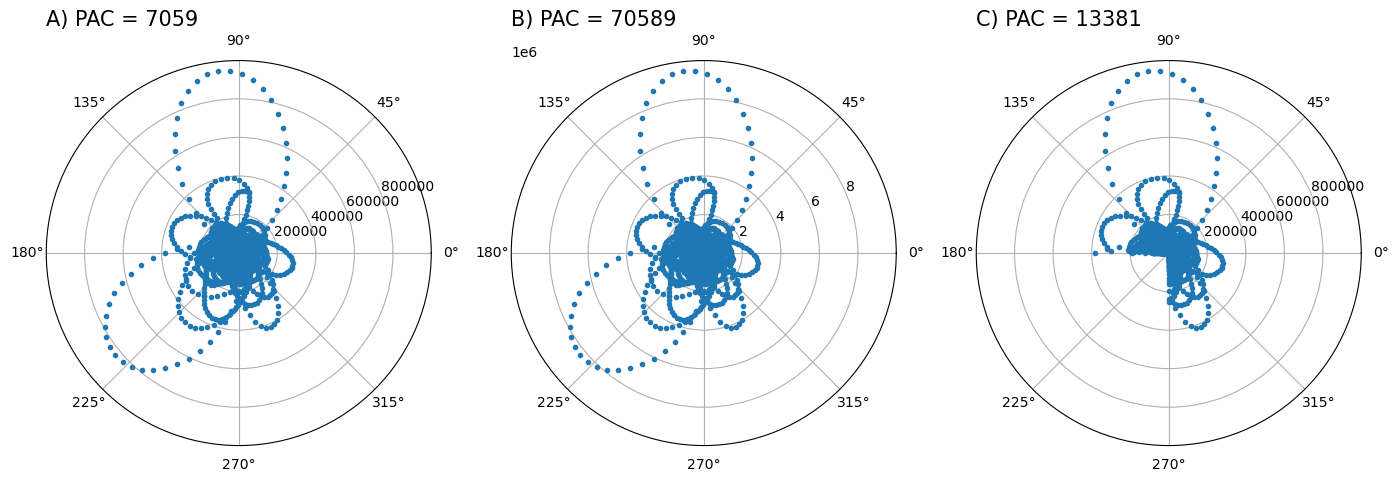

In [8]:
phase_bias = phase.copy()
power_bias = pwr.copy()

mask = phase_bias > -np.pi / 2
phase_bias = phase_bias[mask]
power_bias = power_bias[mask]


plt.figure(figsize=(17,5))
# plot power as a function of phase in polar space
plt.subplot(131, polar=True)
plt.plot(phase, pwr, '.')
plt.title(f'A) PAC = {round(abs(np.mean(pwr * np.exp(1j * phase))))}', loc='left', fontsize=15)

plt.subplot(132, polar=True)
plt.plot(phase, pwr * 10, '.')
plt.title(f'B) PAC = {round(abs(np.mean(pwr * 10 * np.exp(1j * phase))))}', loc='left', fontsize=15)

plt.subplot(133, polar=True)
plt.plot(phase_bias, power_bias, '.')
_=plt.title(f'C) PAC = {round(abs(np.mean(power_bias * np.exp(1j * phase_bias))))}', loc='left', fontsize=15)

## Figure 30.5

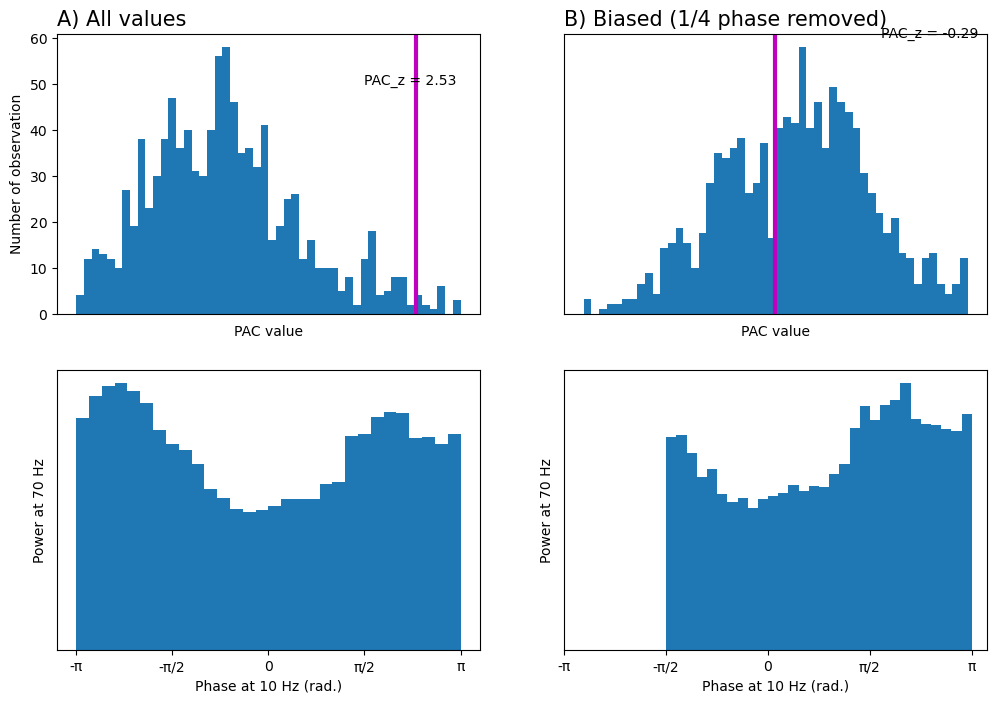

In [9]:
# observed cross-frequency-coupling (note the similarity to Euler's formula)
obsPAC = np.abs(np.mean(pwr * np.exp(1j * phase)))
obsPAC_bias = np.abs(np.mean(power_bias * np.exp(1j * phase_bias)))

num_iter = 1000
permutedPAC = np.zeros((2, num_iter))

for i in range(num_iter):
    random_timepoint = np.random.randint(int(np.shape(eeg)[1] * 0.1), int(np.shape(eeg)[1] * 0.9))
    random_timepoint_bias = np.random.randint(int(len(power_bias) * 0.1), int(len(power_bias) * 0.9))

    timeshiftedpwr = np.roll(pwr, random_timepoint)
    timeshiftedpwr_bias = np.roll(power_bias, random_timepoint_bias)

    permutedPAC[0, i] = abs(np.mean(timeshiftedpwr * np.exp(1j * phase)))
    permutedPAC[1, i] = abs(np.mean(timeshiftedpwr_bias * np.exp(1j * phase_bias)))


# compute PACz
pacz = np.zeros(2)
pacz[0] = (obsPAC - np.mean(permutedPAC[0])) / np.std(permutedPAC[0])
pacz[1] = (obsPAC_bias - np.mean(permutedPAC[1])) / np.std(permutedPAC[1])


plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.hist(permutedPAC[0], bins=50)
plt.axvline(obsPAC, color='m', lw=3)
plt.setp(plt.gca(), 'xlabel', 'PAC value', 'ylabel', 'Number of observation','xticks', [])
plt.text(6000, 50, f'PAC_z = {np.round(pacz[0], 2)}')
plt.title('A) All values', loc='left', fontsize=15)

plt.subplot(222)
plt.hist(permutedPAC[1], bins=50)
plt.axvline(obsPAC_bias, color='m', lw=3)
plt.setp(plt.gca(), 'xlabel', 'PAC value', 'xticks', [], 'yticks', [])
plt.text(16000, 55, f'PAC_z = {np.round(pacz[1], 2)}')
plt.title('B) Biased (1/4 phase removed)', loc='left', fontsize=15)


# plot histogram of power over phase
n_hist_bins=30

phase_edges = np.linspace(np.min(phase), np.max(phase), n_hist_bins + 1)
amp_by_phases = np.array([np.mean(pwr[(phase > phase_edges[i]) & (phase < phase_edges[i + 1])]) for i in range(n_hist_bins)])


plt.subplot(223)
plt.bar(phase_edges[:-1], amp_by_phases, align='edge', width=np.diff(phase_edges).mean())
plt.setp(plt.gca(), 'xlabel', f'Phase at {freq4phase} Hz (rad.)', 'ylabel', f'Power at {freq4power} Hz', 'yticks', [])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', 0, 'π/2', 'π'])


phase_edges = np.linspace(np.min(phase_bias), np.max(phase_bias), n_hist_bins + 1)
amp_by_phases = np.array([np.mean(power_bias[(phase_bias > phase_edges[i]) & (phase_bias < phase_edges[i + 1])]) for i in range(n_hist_bins)])


plt.subplot(224)
plt.bar(phase_edges[:-1], amp_by_phases, align='edge', width=np.diff(phase_edges).mean())
plt.setp(plt.gca(), 'xlabel', f'Phase at {freq4phase} Hz (rad.)', 'yticks',[], 'ylabel', f'Power at {freq4power} Hz', 'yticks', [])
_=plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', 0, 'π/2', 'π'])

## Figure 30.6

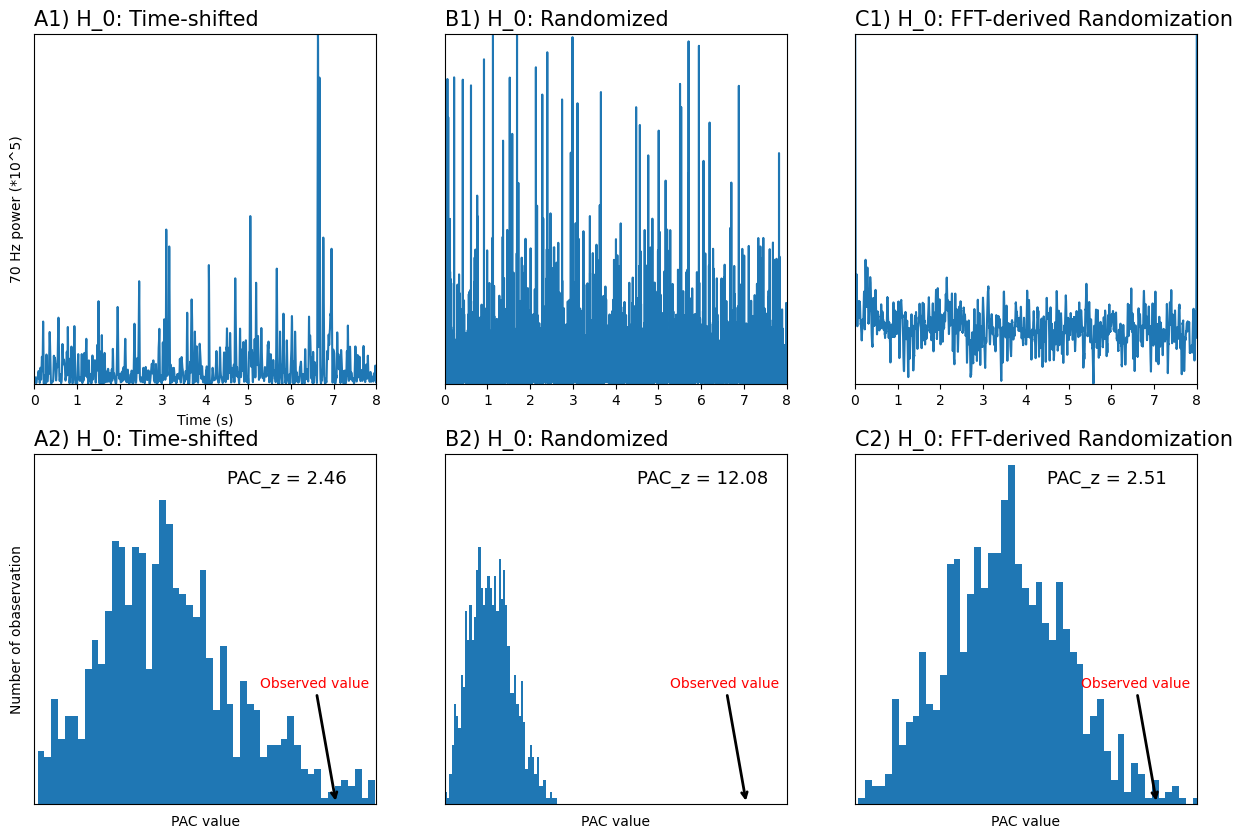

In [10]:
permutedPAC = np.zeros((3, num_iter))

for i in range(num_iter):
    
    # Permutation method 1: select random time point
    random_timepoint = np.random.randint(int(np.shape(eeg)[1] * 0.1), int(np.shape(eeg)[1] * 0.9))
    timeshiftedpwr = np.roll(pwr, random_timepoint)
    permutedPAC[0, i] = np.abs(np.mean(timeshiftedpwr * np.exp(1j * phase)))
    
    # Permutation method 2: totally randomize power time series
    permutedPAC[1, i] = np.abs(np.mean(pwr[np.random.permutation(len(pwr))] * np.exp(1j * phase)))
    
    # Permutation method 3: FFT-based power time series randomization
    f = np.fft.fft(pwr)
    A = np.abs(f)
    zphs = np.cos(np.angle(f)) + 1j * np.sin(np.angle(f))
    powernew = np.real(np.fft.ifft(A * zphs[np.random.permutation(len(zphs))]))
    powernew -= np.min(powernew)
    permutedPAC[2, i] = abs(np.mean(powernew * np.exp(1j * phase)))


# compute PACz and plot
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    
    if i == 0:
        plt.plot(eegtime, timeshiftedpwr)
        plt.title('A1) H_0: Time-shifted', loc='left', fontsize=15)
        plt.xlabel('Time (s)'), plt.ylabel('70 Hz power (*10^5)')
    elif i == 1:
        plt.plot(eegtime, pwr[np.random.permutation(len(pwr))])
        plt.title('B1) H_0: Randomized', loc='left', fontsize=15)
    else:
        plt.plot(eegtime, powernew)
        plt.title('C1) H_0: FFT-derived Randomization', loc='left', fontsize=15)
        
    plt.setp(plt.gca(), 'xlim', [0, eegtime[-1]], 'ylim', [np.min(pwr), np.max(pwr)], 'yticks', [])
    
    # plot null-hypothesis distribution
    plt.subplot(2, 3, i + 4)
    pacz = (obsPAC - np.mean(permutedPAC[i])) / np.std(permutedPAC[i])
    plt.hist(permutedPAC[i], bins=50)
    plt.annotate("Observed value", xy=(obsPAC, 0), size=10, xytext=(obsPAC-500, 20), color="red", 
                 arrowprops=dict(lw=2,facecolor='black', arrowstyle="->"),ha='center')
    plt.setp(plt.gca(), 'xlim', [0, 8000], 'ylim', [0, 60], 'xlabel', 'PAC value', 'xticks', [], 'yticks', [])
    plt.text(4500, 55, f'PAC_z = {np.round(pacz, 2)}', fontsize=13)
    if i == 0:
        plt.title(f'A2) H_0: Time-shifted', loc='left', fontsize=15)
        plt.ylabel('Number of obaservation')
    elif i == 1:
        plt.title(f'B2) H_0: Randomized', loc='left', fontsize=15)
    else:
        plt.title(f'C2) H_0: FFT-derived Randomization', loc='left', fontsize=15)

## Figure 30.7

In [11]:
def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))

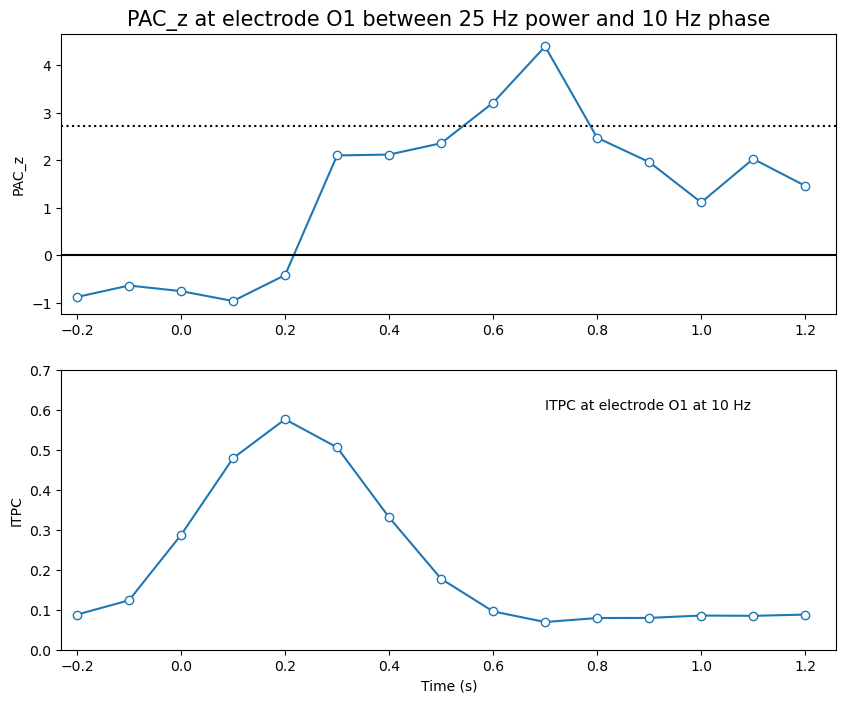

In [12]:
times2plot = np.arange(-.2, 1.201, .1)
freq4phase = 10 #in Hz
freq4power = 25
cfc_numcycles = 3 # number of cycles at phase-frequency
srate = epochs.info['sfreq']

pacz = np.zeros(len(times2plot))
itpc = np.zeros(len(times2plot))

# convert cfc times to indices
cfc_time_window = cfc_numcycles * (1000 / freq4phase)
cfc_time_window_idx = round(cfc_time_window / (1000 / srate))

# convert cfc times to indices
cfc_time_window = cfc_numcycles * (1000 / freq4phase)
cfc_time_window_idx = round(cfc_time_window / (1000 / srate))

# other wavelet parameters
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = int((len(time)-1)/2)
n_wavelet     = len(time)
n_data        = pnts*trials
n_convolution = n_wavelet+n_data-1


# FFT of scalp EEG data
fft_EEG = np.fft.fft(data[:, sensoridx,:].flatten(),n_convolution)



for timei, timepoint in enumerate(times2plot):
    cfc_centertime_idx = dsearchn(times, timepoint)

    # convolution for lower frequency phase
    wavelet = np.exp(2 * 1j * np.pi * freq4phase * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq4phase))**2))
    fft_wavelet = np.fft.fft(wavelet, n_convolution)
    convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    lower_freq_phase = np.reshape(convolution_result, [pnts, trials], order='F')

    # convolution for upper frequency power
    wavelet = np.exp(2 * 1j * np.pi * freq4power * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq4power))**2))
    fft_wavelet = np.fft.fft(wavelet, n_convolution)
    convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    upper_freq_power = np.reshape(convolution_result, [pnts, trials], order='F')

    # extract temporally localized power and phase from task data (not vectorized this time)
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - cfc_time_window_idx//2 : cfc_centertime_idx + cfc_time_window_idx//2, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - cfc_time_window_idx//2 : cfc_centertime_idx + cfc_time_window_idx//2, :])

    # compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))
    # compute lower frequency ITPC
    itpc[timei] = np.mean(np.abs(np.mean(np.exp(1j * phase_ts), axis=1)))


    num_iter = 1000
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        # in contrast to the previous code, this time-shifts the power time series only within trials. Results are similar using either method.
        for triali in range(trials):
            random_timepoint = np.random.randint(int(cfc_time_window_idx * 0.1), int(cfc_time_window_idx * 0.9))
            power_ts[:, triali] = np.roll(power_ts[:, triali], -random_timepoint)

        permutedPAC[i] = np.abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))

    pacz[timei] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)



plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(times2plot, pacz, '-o', markerfacecolor='w')
plt.setp(plt.gca(),'xlim',[min(times2plot) * 1.15, max(times2plot) * 1.05], 'ylabel', 'PAC_z')

# this next line computes the Z-value threshold at p=0.05, correcting for multiple comparisons across time points (this is a bit conservative because of temporal autocorrelation)
# if you don't have the matlab stats toolbox, use a zval of 2.7131 (p<0.05 correcting for 15 time points/comparisons)
zval = stats.norm.ppf(1 - (0.05 / len(times2plot)))
plt.axhline(zval, color='k', linestyle=':')
plt.axhline(0, color='k')
plt.title(f'PAC_z at electrode O1 between {freq4power} Hz power and {freq4phase} Hz phase', fontsize=15)

# Also plot ITPC for comparison
plt.subplot(212)
plt.plot(times2plot, itpc, '-o', markerfacecolor='w')
plt.setp(plt.gca(), 'xlim', [min(times2plot) * 1.15, max(times2plot) * 1.05], 'ylim', [0, 0.7], 'xlabel', 'Time (s)', 'ylabel', 'ITPC')
_=plt.text(.7, .6, f'ITPC at electrode O1 at {freq4phase} Hz')

## Figure 30.8a

In [13]:
phase_freqs = np.arange(2, 21) # Hz
cfc_centertime = .3 # s post-stimulus

pacz1 = np.zeros(len(phase_freqs))
cfc_centertime_idx  = dsearchn(times,cfc_centertime);

for fi, phase_freq in enumerate(phase_freqs):
    
    # convolution for lower frequency phase
    wavelet = np.exp(2 * 1j * np.pi * phase_freq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * phase_freq))**2))
    fft_wavelet = np.fft.fft(wavelet, n_convolution)
    convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
    lower_freq_phase = np.reshape(convolution_result[half_of_wavelet_size:-half_of_wavelet_size], [pnts, trials], order='F')

    
    # extract temporally localized power and phase from task data (not vectorized this time)
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - cfc_time_window_idx // 2 : cfc_centertime_idx + cfc_time_window_idx // 2, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - cfc_time_window_idx // 2 : cfc_centertime_idx + cfc_time_window_idx // 2, :])

    
    # compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))

    
    num_iter = 2000
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        for triali in range(trials):
            random_timepoint = np.random.randint(int(cfc_time_window_idx * 0.1), int(cfc_time_window_idx * 0.9))
            power_ts[:, triali] = np.roll(power_ts[:, triali], -random_timepoint)
        permutedPAC[i] = abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))
        
    
    pacz1[fi] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)

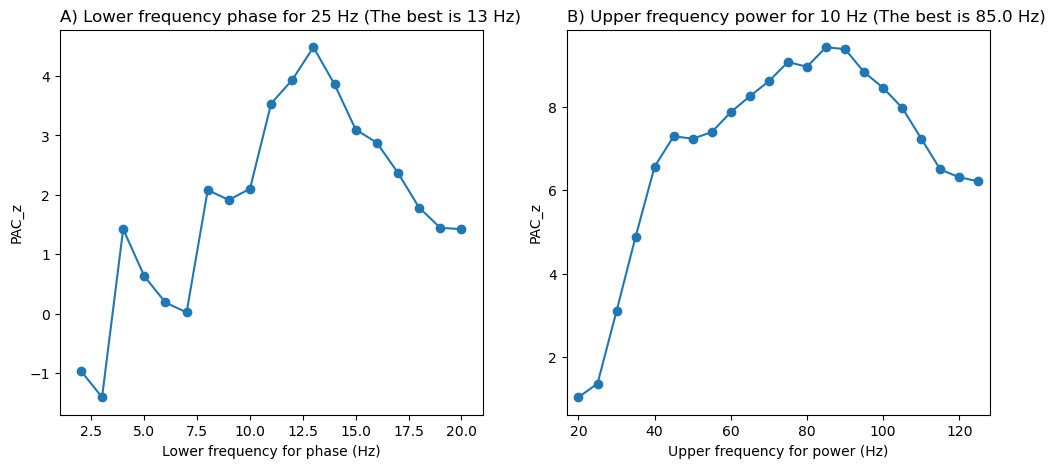

In [14]:
power_freqs = np.arange(20, srate // 2 + 1, 5) # Hz

pacz2 = np.zeros(len(power_freqs))
cfc_centertime_idx  = dsearchn(times,cfc_centertime);

for fi, power_freq in enumerate(power_freqs):
    
    # convolution for lower frequency phase
    wavelet = np.exp(2 * 1j * np.pi * power_freq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * power_freq))**2))
    fft_wavelet = np.fft.fft(wavelet, n_convolution)
    convolution_result = np.fft.ifft(fft_wavelet * fft_EEG, n_convolution)
    upper_freq_power = np.reshape(convolution_result[half_of_wavelet_size:-half_of_wavelet_size], [pnts, trials], order='F')

    
    # extract temporally localized power and phase from task data (not vectorized this time)
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - cfc_time_window_idx // 2 : cfc_centertime_idx + cfc_time_window_idx // 2, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - cfc_time_window_idx // 2 : cfc_centertime_idx + cfc_time_window_idx // 2, :])

    
    # compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))

    
    num_iter = 2000
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        for triali in range(trials):
            random_timepoint = np.random.randint(int(cfc_time_window_idx * 0.1), int(cfc_time_window_idx * 0.9))
            power_ts[:, triali] = np.roll(power_ts[:, triali], -random_timepoint)
        permutedPAC[i] = abs(np.mean(power_ts.flatten() * np.exp(1j * phase_ts.flatten())))
        
    
    pacz2[fi] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(phase_freqs, pacz1, '-o')
plt.xlim([phase_freqs[0] * 0.5, phase_freqs[-1] * 1.05])
plt.xlabel('Lower frequency for phase (Hz)')
plt.ylabel('PAC_z')

max_phase_freq = phase_freqs[np.argmax(pacz1)]
plt.title(f'A) Lower frequency phase for {freq4power} Hz (The best is {max_phase_freq} Hz)', loc = 'left')

plt.subplot(1,2,2)
plt.plot(power_freqs, pacz2, '-o')
plt.xlim([power_freqs[0] - 3, power_freqs[-1] + 3])
plt.xlabel('Upper frequency for power (Hz)')
plt.ylabel('PAC_z')

max_power_freq = power_freqs[np.argmax(pacz2)]
_=plt.title(f'B) Upper frequency power for {freq4phase} Hz (The best is {max_power_freq} Hz)', loc = 'left')

## Figure 30.9

In [15]:
# You have to figure this one out on your own!

## Figure 30.10

In [16]:
# This figure is created by combining the code for figure 30.8. You need
# two loops, one for lower-frequency phase and one for upper-frequency
# power. Compute PAC at each phase-power pair, and then make an image of
# the resulting (z-scored) PAC values. 

## Figure 30.11

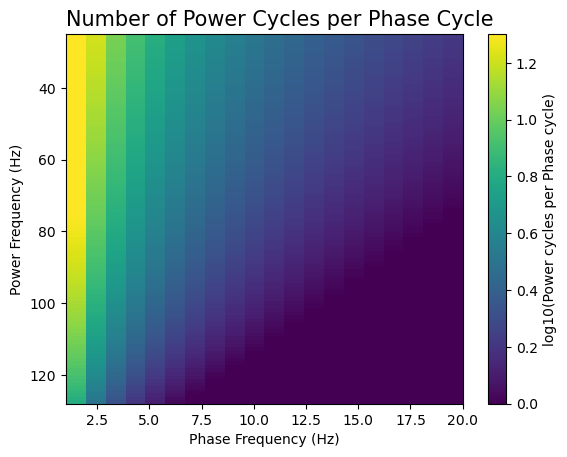

In [17]:
freqs4phase = np.arange(1, 21)
freqs4power = np.arange(25, srate // 2 + 1)

powcycles_per_phscycles = np.zeros((len(freqs4power), len(freqs4phase)))

for phsi, freq4phase in enumerate(freqs4phase):
    for powi, freq4power in enumerate(freqs4power):
        # number of power cycles per phase cycles, scaled by sampling rate
        powcycles_per_phscycles[powi, phsi] = (freq4power / freq4phase) / (1000 / srate)


plt.imshow(np.log10(powcycles_per_phscycles), aspect='auto', extent=[freqs4phase[0], freqs4phase[-1], freqs4power[-1], freqs4power[0]], origin='lower')
plt.clim(np.log10([1, 20]))
plt.colorbar(label='log10(Power cycles per Phase cycle)')
plt.setp(plt.gca(), 'xlabel', 'Phase Frequency (Hz)', 'ylabel','Power Frequency (Hz)')
_=plt.title('Number of Power Cycles per Phase Cycle', fontsize=15, loc='left')

## Figure 30.12

Phase-phase coupling between 12 Hz and 70 Hz is 0.27535472471767514


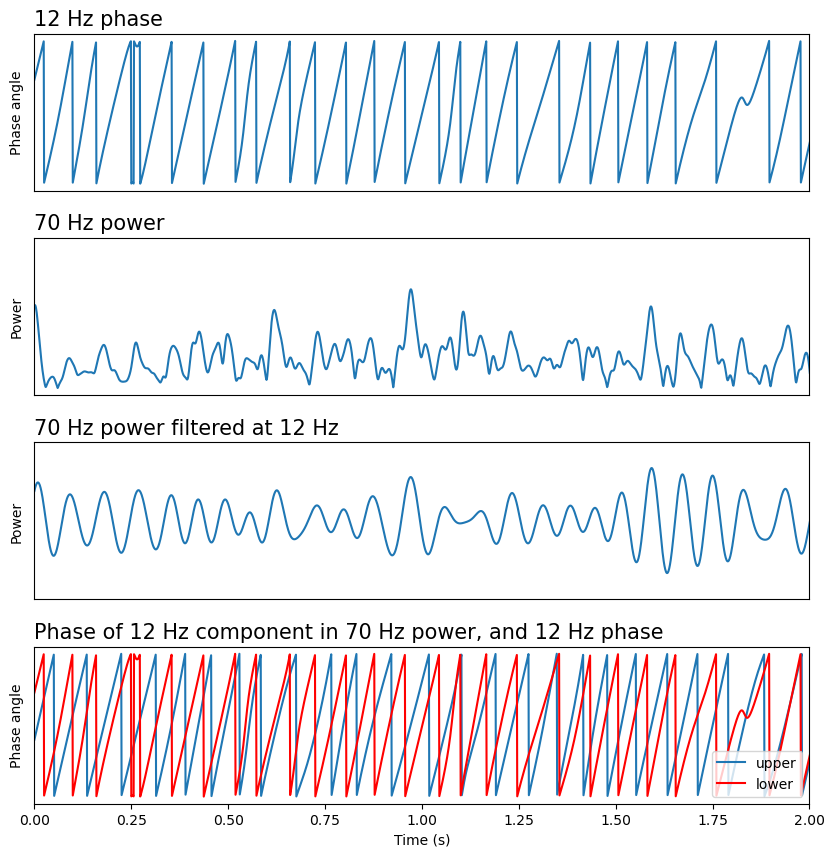

In [18]:
# wavelet parameters
upperfreq = 70
lowerfreq = 12

# other wavelet parameters
time = np.arange(-1, 1 + 1/s_rate, 1/s_rate)
half_of_wavelet_size = int((len(time) - 1) / 2)
n_wavelet = len(time)
n_data = np.shape(eeg)[1]
n_convolution = n_wavelet + n_data - 1

# FFT of data
fft_EEG = np.fft.fft(eeg.flatten(),n_convolution)

# convolution for lower frequency phase (with 4 cycles)
waveletL = np.exp(2 * 1j * np.pi * lowerfreq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * lowerfreq))**2))
fft_waveletL = np.fft.fft(waveletL, n_convolution)
convolution_result = np.fft.ifft(fft_waveletL * fft_EEG, n_convolution)
lowerfreq_phase = np.angle(convolution_result[half_of_wavelet_size:-half_of_wavelet_size])


# convolution for upper frequency (with 4 cycles)
waveletH = np.exp(2 * 1j * np.pi * upperfreq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * upperfreq))**2))
fft_waveletH = np.fft.fft(waveletH, n_convolution)
convolution_result = np.fft.ifft(fft_waveletH * fft_EEG, n_convolution)
upperfreq_amp = np.abs(convolution_result[half_of_wavelet_size:-half_of_wavelet_size])


# filter the upper frequency power in the lower frequency range (in this example, filter at 12 Hz)
# then take the angle from the result of convolution
# (you could achieve the same result by band-pass filtering around 12 Hz and taking the Hilbert transform)
convolution_result = np.fft.ifft(fft_waveletL * np.fft.fft(upperfreq_amp, n_convolution), n_convolution)
upperfreq_amp_phase = np.angle(convolution_result[half_of_wavelet_size:-half_of_wavelet_size])

# plot accumbens alpha phase
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=.3)

plt.subplot(411)
plt.plot(eegtime, lowerfreq_phase)
plt.setp(plt.gca(), 'xticks', [], 'yticks', [], 'xlim', [0,2], 'ylabel', 'Phase angle')
plt.title(f'{lowerfreq} Hz phase', fontsize=15, loc='left')

plt.subplot(412)
plt.plot(eegtime, upperfreq_amp)
plt.setp(plt.gca(), 'xticks', [], 'yticks', [], 'xlim', [0,2], 'ylabel', 'Power')
plt.title(f'{upperfreq} Hz power', fontsize=15, loc='left')

plt.subplot(413)
plt.plot(eegtime, np.real(convolution_result[half_of_wavelet_size:-half_of_wavelet_size]))
plt.setp(plt.gca(), 'xticks', [], 'yticks', [], 'xlim', [0,2], 'ylabel', 'Power')
plt.title(f'{upperfreq} Hz power filtered at {lowerfreq} Hz', fontsize=15, loc='left')

plt.subplot(414)
plt.plot(eegtime, upperfreq_amp_phase)
plt.plot(eegtime, lowerfreq_phase, 'r')
plt.legend(['upper', 'lower'])
plt.title(f'Phase of {lowerfreq} Hz component in {upperfreq} Hz power, and {lowerfreq} Hz phase', fontsize=15, loc='left')
plt.setp(plt.gca(),'yticks', [], 'xlim', [0,2], 'xlabel', 'Time (s)', 'ylabel', 'Phase angle')

# compute synchronization
phasephase_synch = np.abs(np.mean(np.exp(1j * (lowerfreq_phase - upperfreq_amp_phase))))
print(f'Phase-phase coupling between {lowerfreq} Hz and {upperfreq} Hz is {phasephase_synch}')